Test for pyemd
Author: Yanzhen Chen & ChatGPT3.5; Date: 2023.08.21 

In [1]:
pip install pyemd


                                              0.0/148.7 kB ? eta -:--:--
     --                                       10.2/148.7 kB ? eta -:--:--
     --                                       10.2/148.7 kB ? eta -:--:--
     --                                       10.2/148.7 kB ? eta -:--:--
     -------                               30.7/148.7 kB 163.8 kB/s eta 0:00:01
     ----------                            41.0/148.7 kB 219.4 kB/s eta 0:00:01
     ----------                            41.0/148.7 kB 219.4 kB/s eta 0:00:01
     ---------------------------          112.6/148.7 kB 386.4 kB/s eta 0:00:01
     ------------------------------------ 148.7/148.7 kB 492.6 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyemd import emd

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


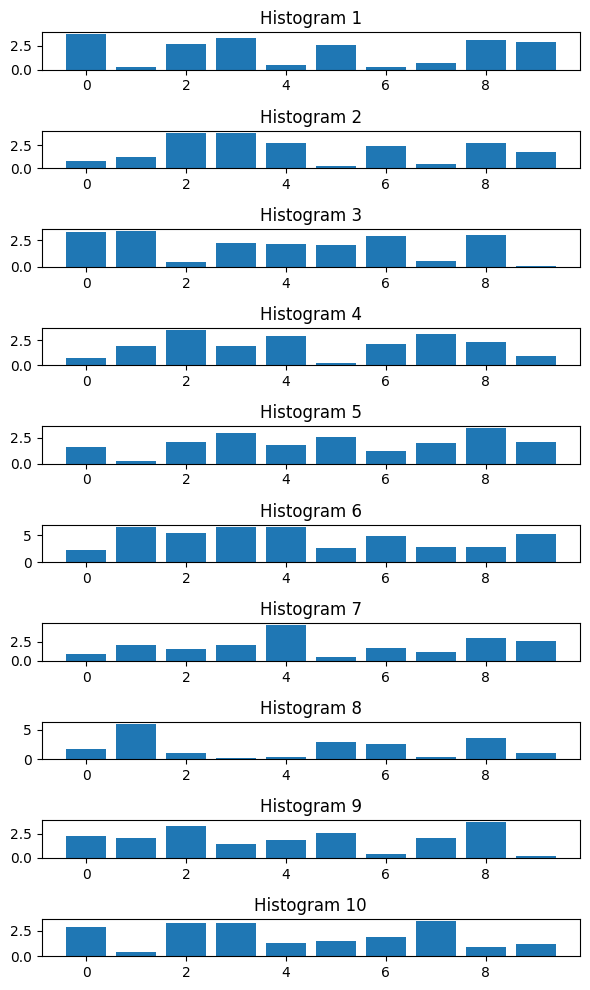

In [4]:
import random
# Parameters
n = 10  # Number of histograms
bins = 10  # Number of bins in each histogram
total_mass = 20

# Creating a distance matrix for the EMD calculation (using absolute differences between bin indices)
distance_matrix_unequal = np.abs(np.arange(bins).reshape(-1, 1) - np.arange(bins).reshape(1, -1))

# Function to generate random histograms with unequal mass and equal bins (robust analysis version)
def generate_histograms_unequal(n, bins, selected_index, unequal_mass):
    histograms = []
    for _ in range(n):
      if _ == selected_index:
        mass = unequal_mass
        hist = np.random.rand(bins)
        hist *= mass / np.sum(hist)
        histograms.append(hist)
      else:
        mass = total_mass  # except one hist is not with the same mass
        hist = np.random.rand(bins)
        hist *= mass / np.sum(hist)  # Normalizing to the given mass
        histograms.append(hist)
    return np.array(histograms)


#Function to get a random index and change the corresponding bin to unequal mass

def get_index(bins):
  return random.randint(0,bins-1)

#Function to get a random unequal mass
def get_different_mass(x):
    while True:
        random_number = random.randint(20, 100)
        if random_number != x:
            return random_number

# Generating n-1 random histograms with equal mass and with different mass
selected_index = get_index(bins)
histograms_unequal = generate_histograms_unequal(n, bins, selected_index, get_different_mass(total_mass))
# Plotting the generated histograms
fig, axes = plt.subplots(n, 1, figsize=(6, 10))
for i, ax in enumerate(axes):
    ax.bar(range(bins), histograms_unequal[i])
    ax.set_title(f'Histogram {i+1}')
plt.tight_layout()
plt.show()

In [11]:
# Function to calculate EMD distance matrix between a set of histograms
def calculate_emd_matrix_unequal_pyemd(histograms, distance_matrix):
    n = len(histograms)
    distance_matrix_emd = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            emd_value= emd(histograms[i], histograms[j], distance_matrix)
            distance_matrix_emd[i, j] = emd_value
    return distance_matrix_emd


In [12]:
# Calculating the EMD distance matrix
distance_matrix_unequal = np.array(distance_matrix_unequal, dtype=np.float64)
distance_matrix_pyemd = calculate_emd_matrix_unequal_pyemd(histograms_unequal, distance_matrix_unequal)
distance_matrix_pyemd

array([[  0.        ,  12.89236711,  14.16052762,  13.68390632,
         15.56147141, 235.51312249,  12.35266765,  15.37780462,
          9.98173475,   9.84575015],
       [ 12.89236711,   0.        ,  15.10612489,   8.96349104,
         14.38136562, 234.        ,  11.85485102,  15.35760464,
         11.95360805,   9.35443065],
       [ 14.16052762,  15.10612489,   0.        ,  15.17448574,
         24.99149158, 234.99497901,  21.8730596 ,  12.32579238,
          7.8022922 ,  10.24402976],
       [ 13.68390632,   8.96349104,  15.17448574,   0.        ,
         11.66126834, 234.37338163,   8.48847151,  15.28404472,
         10.16672983,   8.22001178],
       [ 15.56147141,  14.38136562,  24.99149158,  11.66126834,
          0.        , 234.54399546,   6.75615324,  18.84504717,
         18.74811493,  17.43553346],
       [235.51312249, 234.        , 234.99497901, 234.37338163,
        234.54399546,   0.        , 234.1043279 , 235.12713687,
        234.86475314, 235.11393489],
       [ 1

In [14]:
# Tolerance for checking symmetry
tolerance = 1e-5

# Function to verify whether a given matrix is a distance metric with a given tolerance for symmetry
def is_distance_metric_with_tolerance(matrix, tolerance):
    n = matrix.shape[0]

    # Checking non-negativity
    if not (matrix >= 0).all():
        return False, "Non-negativity violated"

    # Checking identity of indiscernibles
    if not all(matrix[i, i] == 0 for i in range(n)):
        return False, "Identity of indiscernibles violated"

    # Checking symmetry with given tolerance
    if not np.allclose(matrix, matrix.T, atol=tolerance):
        return False, "Symmetry violated (within tolerance)"

    # Checking triangle inequality
    for i in range(n):
        for j in range(n):
            for k in range(n):
                if matrix[i, j] + matrix[j, k] < matrix[i, k]:
                    return False, "Triangle inequality violated"

    return True, "Distance metric verified"

# Verifying whether the distance matrix is a distance metric
is_distance_metric_result = is_distance_metric_with_tolerance(distance_matrix_pyemd, tolerance)
is_distance_metric_result

(True, 'Distance metric verified')

# Compute the accuracy(relative error) of pyemd

$$
||D_{pyemd} - D_{LP}||_F / ||D_{LP}||_F
$$

In [15]:
from scipy.optimize import linprog
# Function to calculate pairwise Earth Mover's Distance (EMD) between two histograms using linear programming
def calculate_pairwise_emd_unequal(hist1, hist2, distance_matrix):
    c = distance_matrix.flatten()
    A_ub = []
    for i in range(len(hist1)):
        row = np.zeros_like(distance_matrix)
        row[i, :] = 1
        A_ub.append(row.flatten())
    for i in range(len(hist2)):
        row = np.zeros_like(distance_matrix)
        row[:, i] = 1
        A_ub.append(row.flatten())
    A_ub = np.array(A_ub)
    A_eq = np.ones((len(hist1),len(hist2))).flatten()
    A_eq = np.repeat(A_eq,2)
    A_eq = A_eq.reshape(2,-1)
    b_ub = np.concatenate([hist1, hist2])
    b_eq = []
    b_eq.append(min(np.sum(hist1),np.sum(hist2)))
    b_eq.append(min(np.sum(hist1),np.sum(hist2)))
    b_eq = np.array(b_eq)
    result = linprog(c, A_ub=A_ub, A_eq=A_eq, b_ub=b_ub, b_eq=b_eq, bounds=[(0,None) for _ in range(len(hist1)*len(hist2))], method='highs')
    flow = result.x.reshape(distance_matrix.shape)
    emd = np.sum(flow * distance_matrix)
    return emd, flow

# Function to calculate EMD distance matrix between a set of histograms
def calculate_emd_matrix_unequal(histograms, distance_matrix):
    n = len(histograms)
    distance_matrix_emd = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            emd_value, _ = calculate_pairwise_emd_unequal(histograms[i], histograms[j], distance_matrix)
            distance_matrix_emd[i, j] = emd_value
    return distance_matrix_emd

# Calculating the EMD distance matrix

distance_matrix_emd = calculate_emd_matrix_unequal(histograms_unequal, distance_matrix_unequal)
distance_matrix_emd

array([[ 0.        , 12.89239645, 14.16058369, 13.68387724, 15.56155341,
         1.51311993, 12.35267609, 15.3778538 ,  9.9817623 ,  9.8457454 ],
       [12.89239645,  0.        , 15.10618001,  8.96354423, 14.38135205,
         0.        , 11.8548983 , 15.35775163, 11.95360012,  9.35445307],
       [14.16058369, 15.10618001,  0.        , 15.17451008, 24.99140973,
         0.99497322, 21.87307035, 12.32592361,  7.80231073, 10.24404592],
       [13.68387724,  8.96354423, 15.17451008,  0.        , 11.66131124,
         0.37337319,  8.48847689, 15.28407798, 10.16681876,  8.22009515],
       [15.56155341, 14.38135205, 24.99140973, 11.66131124,  0.        ,
         0.54402832,  6.75615171, 18.84512415, 18.7479799 , 17.43542412],
       [ 1.51311993,  0.        ,  0.99497322,  0.37337319,  0.54402832,
         0.        ,  0.10434791,  1.12713968,  0.86477591,  1.11395519],
       [12.35267609, 11.8548983 , 21.87307035,  8.48847689,  6.75615171,
         0.10434791,  0.        , 19.22154289

In [19]:
from numpy.lib import diff
# Function to compute accuracy of pyemd
def get_accuracy(distance_matrix_emd, distance_matrix_pyemd):
  diff_matrix = distance_matrix_pyemd - distance_matrix_emd
  norm_emd = np.linalg.norm(distance_matrix_emd,'fro')
  norm_diff = np.linalg.norm(diff_matrix,'fro')
  result = norm_emd / norm_diff
  return result

accuracy = 1 - get_accuracy(distance_matrix_emd, distance_matrix_pyemd)
accuracy


0.880581659041922

# Check the different in operating time

In [27]:
import time
# the time consumed when operating pyemd for 10 times
st = time.time()
cnt = 1
while cnt<=10:
  selected_index = get_index(bins)
  histograms_unequal = generate_histograms_unequal(n, bins, selected_index, get_different_mass(total_mass))
  distance_matrix_unequal = np.array(distance_matrix_unequal, dtype=np.float64)
  distance_matrix_pyemd = calculate_emd_matrix_unequal_pyemd(histograms_unequal, distance_matrix_unequal)
  cnt += 1
ed = time.time()
print('time elapsed:',ed-st)


time elapsed: 0.0902099609375


In [28]:
# the time consumed when operating linprog for 10 times
st = time.time()
cnt = 1
while cnt<=10:
  selected_index = get_index(bins)
  histograms_unequal = generate_histograms_unequal(n, bins, selected_index, get_different_mass(total_mass))
  distance_matrix_unequal = np.array(distance_matrix_unequal, dtype=np.float64)
  distance_matrix_pyemd = calculate_emd_matrix_unequal(histograms_unequal, distance_matrix_unequal)
  cnt += 1
ed = time.time()
print('time elapsed:',ed-st)


time elapsed: 2.112043857574463


# The difference between pyemd and solving LP

1. pyemd guarantees emd after solving can be a metric while linprog cannot;
  given the condition that all except one histogram has the same mass
2. the operating time of solving LP is more than 20 times of pyemd